In [26]:
import scipy
from scipy.signal import butter, lfilter, freqz
from scipy.signal import stft
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pyroomacoustics as pra
import pydub
from pydub import AudioSegment
from pydub.playback import play

In [4]:
PATH = "audio/test sandberg/"

In [8]:
def display_left_right(audio_data):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(2, 1, 1)
    plt.plot(audio_data[:,0], label='left')
    plt.plot(audio_data[:,1], label='right')

    plt.subplot(2, 1, 2)
    plt.plot(audio_data[:,0] - audio_data[:,1], label='diff')
    plt.legend()
    plt.show()

In [12]:
TEST_1M = PATH + "test 1m.wav"

In [21]:
rate, data = scipy.io.wavfile.read(TEST_1M)
sr = rate
print("rate: ", rate)

rate:  44100


In [14]:
IPython.display.Audio(TEST_1M)

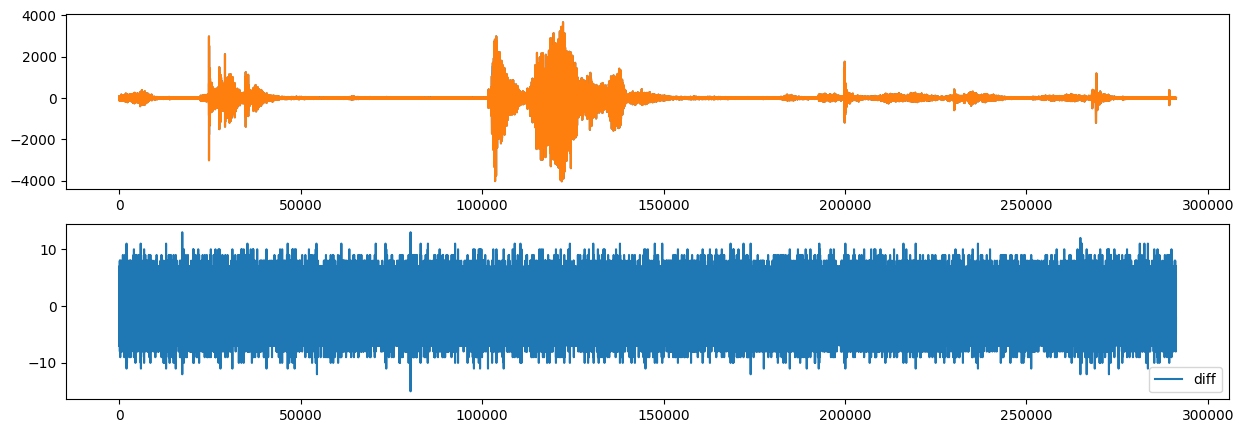

In [15]:
display_left_right(data)

In [22]:
def compute_doa_grid_val(stereo_input, fft_length=512, sampling_freq=48000, inter_mic_dist=0.16):
    R = np.array([[0, inter_mic_dist], [0, 0]])

    # compute the STFT for each channel
    _, _, Zxx_1 = stft(stereo_input[:,0], fs=sampling_freq, nperseg=fft_length)
    _, _, Zxx_2 = stft(stereo_input[:,1], fs=sampling_freq, nperseg=fft_length)

    Zxx = np.stack((Zxx_1, Zxx_2), axis=0)


    doa = pra.doa.NormMUSIC(R, fs = sr, nfft=fft_length)
    doa.locate_sources(Zxx)
    return doa.grid.values

def compute_doa_azimuth(stereo_input, fft_length=512, sampling_freq=48000, inter_mic_dist=0.16):
    R = np.array([[0, inter_mic_dist], [0, 0]])

    # compute the STFT for each channel
    _, _, Zxx_1 = stft(stereo_input[:,0], fs=sampling_freq, nperseg=fft_length)
    _, _, Zxx_2 = stft(stereo_input[:,1], fs=sampling_freq, nperseg=fft_length)

    Zxx = np.stack((Zxx_1, Zxx_2), axis=0)


    doa = pra.doa.NormMUSIC(R, fs = sr, nfft=fft_length)
    doa.locate_sources(Zxx)
    return doa.grid.azimuth

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def doa_from_audio(audio_data, window_size=30000, step_size=500, lowpass_doa = True):
    """Returns the angle of the source in degrees (-90 to 90)"""

    spatial_resp = []

    for i in range(int(window_size/2), int(audio_data.shape[0]-window_size/2), step_size):
        #print(i)
        window = audio_data[int(i-window_size/2):int(i+window_size/2)]
        if np.mean(np.abs(window)) < 300: #peak detection - 300 is forged value, will need adaption when using the final hardware
            spatial_resp.append(0)
            continue
        temp = compute_doa_grid_val(window)
        temp[180:] = 0 # we only take the first half of the spectrum
        angle = (np.argmax(temp))
        angle = angle-90
        spatial_resp.append(angle)

    # lowpass filter to smooth out the response
    if lowpass_doa:
        spatial_resp = butter_lowpass_filter(spatial_resp, 100, 6000)

    return spatial_resp

def plot_doa_from_audio(audio_data, window_size=30000, step_size=500, lowpass_doa = True):
    spatial_resp = doa_from_audio(audio_data, window_size, step_size, lowpass_doa)

    # compute new index for plotting
    index = np.zeros_like(spatial_resp)
    for i in range(len(spatial_resp)):
        index[i] = i*step_size
    
    fig,ax = plt.subplots()
    fig.suptitle("audio and doa")

    ax.plot(audio_data[:,0], color = "blue")
    ax.set_ylabel("amplitude of the audio signal", color = "blue")
    ax.set_xlabel("time (samples)")

    ax2 = ax.twinx()
    ax2.plot(index, spatial_resp, color = "orange")
    ax2.set_ylabel("doa azimuth (deg)", color = "orange")
    plt.plot(spatial_resp)
    plt.show()

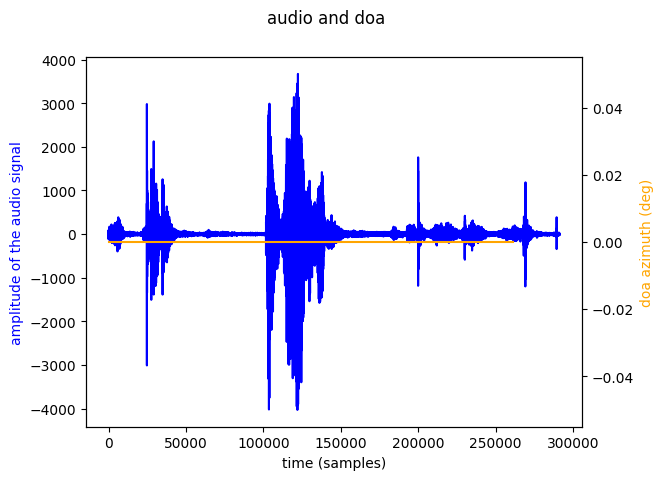

In [23]:
plot_doa_from_audio(data)

In [32]:
wav_file =  pydub.AudioSegment.from_file(file = TEST_1M,
                                         format = "wav")
louder_wav_file = wav_file + 20

In [33]:
louder_wav_file.export("audio/test sandberg/test 1m louder.wav", format = "wav")

<_io.BufferedRandom name='audio/test sandberg/test 1m louder.wav'>